# Hotel Reviews in Europe

In this notebook we will use [Hotel Reviews Data in Europe](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe) dataset for searching hotels by user's query. For each hotel in dataset we will create a vector. That vector will be an average of all hotel's review vectors. Finally we will try to find hotels suitable to some user's query using Vektonn.

## Install necessary dependencies

In [1]:
! pip install --upgrade geopy matplotlib nltk pandas sklearn vektonn

from IPython.display import clear_output
clear_output()

In [2]:
! pip list | grep vektonn

vektonn                0.6.0               


In [3]:
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

## Get dataset and make some EDA

Dataset - https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

First we need to download it and put into `.data` directory. One can use `download-dataset.sh` script located in the current directory.

Then we can read it:

In [4]:
hotel_reviews = pd.read_csv('.data/Hotel_Reviews.csv')
print(hotel_reviews.shape)

(515738, 17)


Show number of hotels:

In [5]:
hotel_reviews.Hotel_Name.nunique()

1492

Get hotel average score histogram:

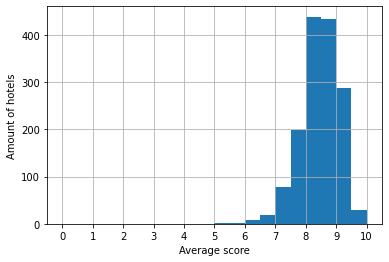

In [6]:
hotel_reviews.groupby('Hotel_Name')['Reviewer_Score'].mean().hist(bins=20, range=[0, 10])
plt.xticks(range(0, 11))
plt.xlabel('Average score')
plt.ylabel('Amount of hotels')
plt.show()

Explore hotel locations:

In [7]:
cities = hotel_reviews['Hotel_Address'].str.split().str[-2].unique()

In [8]:
cities = np.where(cities == 'United', 'London', cities)

In [9]:
geolocator = Nominatim(user_agent="my_app")

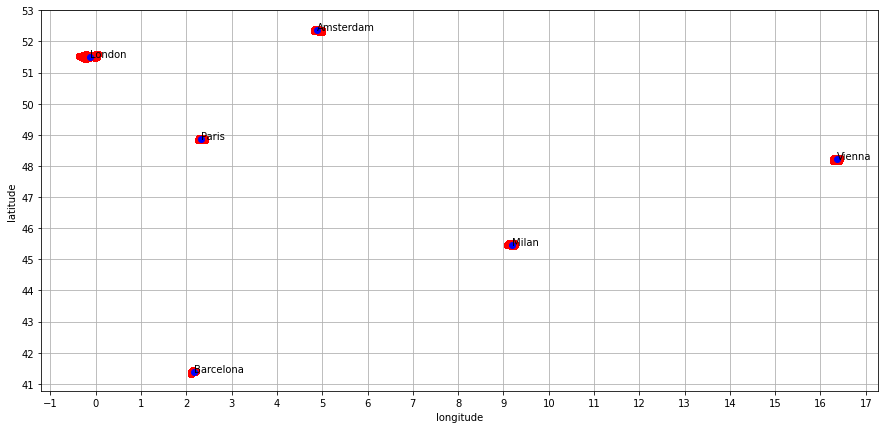

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(hotel_reviews['lng'], hotel_reviews['lat'], 'ro')
for city in cities:
    location = geolocator.geocode(city)
    plt.plot(location.longitude, location.latitude, 'bo')
    plt.annotate(city, (location.longitude, location.latitude))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.xticks(range(-1, 18))
plt.yticks(range(41, 54))
plt.show()

## Prepare hotel reviews embeddings

For embeddings generation we are going to use TfIdf.

Before vectorization we want to lemmatize words in reviews for better results.

In [11]:
nltk.data.path.append('.data/nltk_data')
nltk.download('wordnet', download_dir='.data/nltk_data')
nltk.download('punkt', download_dir='.data/nltk_data')

[nltk_data] Downloading package wordnet to .data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to .data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Let's use only positive reviews.

In [12]:
hotel_positive_reviews = hotel_reviews.copy()
hotel_positive_reviews['Positive_Review'] = hotel_positive_reviews['Positive_Review'].replace('No Positive', np.nan)
hotel_positive_reviews = hotel_positive_reviews.dropna(subset=['Positive_Review']).reset_index(drop=True)
print(hotel_positive_reviews.shape)

(479792, 17)


### Text lemmatization

In [13]:
lemmatizer = WordNetLemmatizer()
tokenized_text = []

for sentence in tqdm(hotel_positive_reviews['Positive_Review'].values):
    tokenized_sentence = ' '.join([lemmatizer.lemmatize(x).lower() for x in word_tokenize(sentence)])
    tokenized_text.append(tokenized_sentence)
    
hotel_positive_reviews['Positive_Review_lemmatized'] = tokenized_text

  0%|          | 0/479792 [00:00<?, ?it/s]

### Text vectorization

In [14]:
vectorizer = TfidfVectorizer(max_features=128, stop_words='english')
vectorized_text = vectorizer.fit_transform(hotel_positive_reviews['Positive_Review_lemmatized'].values).toarray()
print(vectorized_text.shape)

(479792, 128)


Calculating the average review vector for each hotel.

In [15]:
hotel_names = hotel_positive_reviews['Hotel_Name'].unique()

final_vectors = np.zeros((len(hotel_names), vectorized_text.shape[1]))

for i, hotel_name in enumerate(tqdm(hotel_positive_reviews['Hotel_Name'].unique())):
    indexes = hotel_positive_reviews[hotel_positive_reviews['Hotel_Name'] == hotel_name].index
    final_vectors[i, :] = vectorized_text[indexes].mean(axis=0)

  0%|          | 0/1492 [00:00<?, ?it/s]

### Example

In [16]:
def prepare_text(review, vectorizer):
    tokenized_review = ' '.join([lemmatizer.lemmatize(x).lower() for x in word_tokenize(review)])
    return vectorizer.transform([tokenized_review]).toarray()

review_idx = 0
review = hotel_reviews['Positive_Review'][review_idx]
print(f'{hotel_reviews["Hotel_Name"][review_idx]}: {review}')

review_vector = prepare_text(review, vectorizer)
print(review_vector.shape)

Hotel Arena:  Only the park outside of the hotel was beautiful 
(1, 128)


In [17]:
hotel_names[np.linalg.norm(final_vectors - review_vector, axis=1).argmin()]

'Hotel Seven One Seven'

## Use Vektonn

### Setup data source and index schema

Define Vektonn data source:

In [18]:
%%bash

data_source_schema_dir=../../docker/config/data-sources/Examples.Hotels
mkdir -p $data_source_schema_dir

cat <<EOF > "$data_source_schema_dir/1.0.yaml"
vectorDimension: 128
vectorsAreSparse: false
attributeValueTypes:
  Id: Int64
  Name: String
  AverageScore: Float64
  Longitude: Float64
  Latitude: Float64
permanentAttributes: ["Id"]
EOF

Define Vektonn index:

In [19]:
%%bash

index_schema_dir=../../docker/config/indices/Examples.Hotels
mkdir -p $index_schema_dir

cat <<EOF > "$index_schema_dir/1.0.yaml"
dataSourceId:
  name: Examples.Hotels
  version: 1.0
indexAlgorithm:
  type: FaissIndex.L2
idAttributes: ["Id"]
shardsById:
  SingleShard: {}
EOF

cat <<EOF > "../../docker/config/index-shards-topology.yaml"
Examples.Hotels:
  1.0:
    SingleShard: vektonn-index-shard:8082
EOF

### Start Vektonn services

In [20]:
! ../../docker/run-vektonn.sh Examples.Hotels
clear_output()

Init Vektonn API client:

In [21]:
from vektonn import Vektonn

vektonn_client = Vektonn('http://localhost:8081')

### Upload data points

Prepare hotel attributes:

In [22]:
hotel2average_score = hotel_reviews.groupby('Hotel_Name')['Reviewer_Score'].mean().to_dict()
hotel2longitude = hotel_reviews.groupby('Hotel_Name')['lng'].mean().fillna(0.0).to_dict()
hotel2latitude = hotel_reviews.groupby('Hotel_Name')['lat'].mean().fillna(0.0).to_dict()

Upload vectors and corresponding attributes to Vektonn:

In [23]:
from vektonn.dtos import InputDataPoint, Attribute, AttributeValue, Vector

data_source_name = 'Examples.Hotels'
data_source_version = '1.0'

input_data_points = []
for idx, hotel_name in enumerate(hotel_names):
    input_data_points.append(InputDataPoint(
        attributes=[
            Attribute(key='Id', value=AttributeValue(int64=idx)),
            Attribute(key='Name', value=AttributeValue(string=hotel_name)),
            Attribute(key='AverageScore', value=AttributeValue(float64=hotel2average_score[hotel_name])),
            Attribute(key='Longitude', value=AttributeValue(float64=hotel2longitude[hotel_name])),
            Attribute(key='Latitude', value=AttributeValue(float64=hotel2latitude[hotel_name])),
        ],
        vector=Vector(is_sparse=False, coordinates=final_vectors[idx].tolist()),
    ))

try:
    vektonn_client.upload(data_source_name, data_source_version, input_data_points)
    print(f'Successfully uploaded {len(input_data_points)} data points')
except BaseException as err:
    print(f'Unexpected error: {repr(err)}')

Successfully uploaded 1492 data points


In [24]:
# wait a bit for Vektonn data indexing
import time
time.sleep(5)

### Search for similiar hotels

Let's imagine a user1 who pays attention on view from hotel room window, quality of breakfast and wants to relax. 
And user2 who wants to stay in hotel in quiet distrtict and is going to move to next destination after sleeping on comfortable bed.

Probably their search queries would look like that:

In [25]:
user_query1 = 'Hotel with beautiful view of old town, tasty breakfast and spa'
user_query2 = 'Hotel in quiet place, not far from train station and with huge bed'

We have to create a vector representation of the users' queries.

In [26]:
user_query_vector1 = prepare_text(user_query1, vectorizer)
user_query_vector2 = prepare_text(user_query2, vectorizer)

display(user_query_vector1[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.63441402, 0.        ,
       0.        , 0.        , 0.38419395, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.35085709, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

And then we search in space for vectors similar to users' query vectors.

In [27]:
from vektonn.dtos import SearchQuery, Vector

index_name = 'Examples.Hotels'
index_version = '1.0'

search_query = SearchQuery(k=5, query_vectors=[
    Vector(is_sparse=False, coordinates=user_query_vector1[0].tolist()),
    Vector(is_sparse=False, coordinates=user_query_vector2[0].tolist()),
])

try:
    search_results = vektonn_client.search(index_name, index_version, search_query)
    display(search_results[0].nearest_data_points[0].attributes)
except BaseException as err:
    print(f'Unexpected error: {repr(err)}')

[Attribute(key='Id', value=AttributeValue(string=None, guid=None, bool=None, int64=1269, float64=None, date_time=None)),
 Attribute(key='AverageScore', value=AttributeValue(string=None, guid=None, bool=None, int64=None, float64=8.171649484536083, date_time=None)),
 Attribute(key='Latitude', value=AttributeValue(string=None, guid=None, bool=None, int64=None, float64=0.0, date_time=None)),
 Attribute(key='Longitude', value=AttributeValue(string=None, guid=None, bool=None, int64=None, float64=0.0, date_time=None)),
 Attribute(key='Name', value=AttributeValue(string='Austria Trend Hotel Schloss Wilhelminenberg Wien', guid=None, bool=None, int64=None, float64=None, date_time=None))]

Which hotels have most suitable reviews? Let's see.

In [28]:
for user_query, search_result in zip([user_query1, user_query2], search_results):
    print(f'For query "{user_query}" the following hotels are recommended:')
    for data_point in search_result.nearest_data_points:
        attributes = {x.key : x.value for x in data_point.attributes}
        print(attributes['Name'].string)
    print()

For query "Hotel with beautiful view of old town, tasty breakfast and spa" the following hotels are recommended:
Austria Trend Hotel Schloss Wilhelminenberg Wien
Gran Hotel La Florida
Hotel Miramar Barcelona GL
Novotel London Canary Wharf
Shangri La Hotel at The Shard London

For query "Hotel in quiet place, not far from train station and with huge bed" the following hotels are recommended:
AC Hotel Sants a Marriott Lifestyle Hotel
Barcel Sants
AZIMUT Hotel Vienna
Hotel Zeitgeist Vienna Hauptbahnhof
Urban Lodge Hotel

